In [1]:
from utils import extract_data_and_folds,prepare_datasets
import pandas as pd

In [2]:
# Paso 1: Extraer datos y folds

metadata_df = pd.read_csv(r'D:\data\ml2\metadata\UrbanSound8k.csv')
audio_directory = r'D:\data\ml2\audio'
features, labels, folds = extract_data_and_folds(audio_directory, metadata_df)




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from models import cross_validate,ImprovedGRUModel
import importlib
import models  
importlib.reload(models)
import foolbox as fb
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import librosa.display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(f"Entrenando en GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No hay GPUs disponibles. El entrenamiento se realizará en la CPU.")
    
config = {
    "learing_rate": 0.005,
    "hidden_dim1": 8,
    "hidden_dim2": 8,
    "output_dim": 10,
    "dropout_rate": 0.01,
    "weight_decay": 1e-4,
}




avg_results, train_class, valid_class, results,final_model,X_train_padded, X_test_padded, y_train_numeric, y_test_numeric= cross_validate("GRU",config,features,labels,folds,epochs = 20,device = device,verbose=2)




No hay GPUs disponibles. El entrenamiento se realizará en la CPU.
{'train_losses': np.float64(1.9258145085036835), 'valid_losses': np.float64(1.925691115544829), 'train_accuracies': np.float64(0.31073025854401537), 'train_f1_scores': np.float64(0.2657105412548517), 'train_recalls': np.float64(0.31073025854401537), 'valid_accuracies': np.float64(0.3078659259922196), 'valid_f1_scores': np.float64(0.2504298873695946), 'valid_recalls': np.float64(0.3078659259922196)}


# Deep Fool


In [ ]:
from foolbox.attacks import LinfDeepFoolAttack,LinfPGD,L2DeepFoolAttack
# X_train_padded, X_test_padded, y_train_numeric, y_test_numeric =
model = final_model.to(device)

# for i in range (1,11):

input_bounds = (X_train_padded.min(), X_train_padded.max())         #Creamos los límites, en este caso el minimo y máximo de nuestro conjunto de entrenamiento 

# Crear el objeto Foolbox model
fmodel = fb.PyTorchModel(model, bounds=input_bounds, device=device)

#Ejemplos que "atacaremos"
num_examples = 100
indices = np.random.choice(len(X_test_padded), num_examples, replace=False)
X_attack = torch.tensor(X_test_padded[indices], dtype=torch.float32).to(device)
print(f"Dimensiones completas X_attack: {X_attack.shape}")

y_attack = torch.tensor(y_test_numeric[indices], dtype=torch.long).to(device)
print(f"Dimensiones completas y_attack: {y_attack.shape}")

attack = L2DeepFoolAttack()
# Definimos epsilon que es el límite máximo de la magnitud de la perturbación adversarial
# epsilons = np.linspace(0.01, 0.5, 30)


# Aplicar el ataque para cada epsilon
adversarials = attack(fmodel, X_attack, y_attack,epsilons=None)

# ###########################################################################################################################################################################
attack = LinfPGD()
# Visualizar un ejemplo exitoso
def plot_features(original, adversarial, index):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original.T, aspect='auto', origin='lower')
    plt.title(f'Original - Clase {y_attack[index].item()}')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(adversarial.T, aspect='auto', origin='lower')
    plt.title(f'Adversarial - Clase {adversarial_preds[index].item()}')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

epsilons = [10**(float(x)) for x in [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0]]
adversarials = attack(fmodel, X_attack, y_attack,epsilons=epsilons)

adversarial_examples_list = adversarials[0]  # Lista de ejemplos adversariales por epsilon
perturbations_list = adversarials[1]         # Lista de perturbaciones por epsilon
success_flags = adversarials[2]              # Tensor de éxitos de forma [4, 100]
resultados=[]                                # Almacenar resultados 
# Iterar sobre cada epsilon y los ejemplos adversariales correspondientes
for i, epsilon in enumerate(epsilons):
    adversarial_examples = adversarial_examples_list[i]  # Tensor de forma [100, 172, 2]
    
    # Asegurar que los ejemplos adversariales estén en el dispositivo correcto ¿Porque hay que hacer esto?
    adversarial_examples = adversarial_examples.to(device)
    
    # Obtener las predicciones adversariales
    adversarial_preds = fmodel(adversarial_examples).argmax(axis=-1)  # Tensor de forma [100]
    
    # Calcular la tasa de éxito del ataque
    success = adversarial_preds != y_attack
    success_rate = success.float().mean().item()
    print(f"Tasa de éxito para epsilon={epsilon}: {success_rate * 100:.2f}%")
    resultados.append(success_rate)

resultados_percent = [r * 100 for r in resultados]


# Crear el plot
plt.figure(figsize=(8, 6))
plt.plot(epsilons , resultados_percent, marker='o', linestyle='-')
plt.title("Resultados en Porcentaje")
plt.xlabel("Epsilon ")
plt.ylabel("Efectividad del ataque (%)")
plt.grid(True)
plt.show()



# Seleccionar el índice del epsilon para visualizar (por ejemplo, el de epsilon=0.1)
epsilon_target = 0.1

# Convertir epsilons a array de NumPy si es necesario
if isinstance(epsilons, list):
    epsilons_array = np.array(epsilons)
else:
    epsilons_array = epsilons

epsilon_index = (np.abs(epsilons_array - epsilon_target)).argmin()

# Extraer los ejemplos adversariales y predicciones correspondientes al epsilon seleccionado
adversarial_examples = adversarial_examples_list[epsilon_index]  # Tensor de forma [100, 172, 2]
adversarial_examples = adversarial_examples.to(device)

# Obtener las predicciones adversariales correspondientes
adversarial_preds = fmodel(adversarial_examples).argmax(axis=-1)  # Tensor de forma [100]


# Obtener los índices de ejemplos donde el ataque tuvo éxito
success = adversarial_preds != y_attack
successful_indices = np.where(success.cpu().numpy())[0]

if len(successful_indices) > 0:
    example_idx = successful_indices[0]
    original = X_attack[example_idx].cpu().numpy()
    adversarial = adversarial_examples[example_idx].cpu().numpy()
    plot_features(original, adversarial, example_idx)
else:
    print("No hubo ataques exitosos para visualizar.")


Dimensiones completas X_attack: torch.Size([100, 172, 2])
Dimensiones completas y_attack: torch.Size([100])
Tasa de éxito para epsilon=0.001: 67.00%
Tasa de éxito para epsilon=0.01: 70.00%
Tasa de éxito para epsilon=0.1: 76.00%


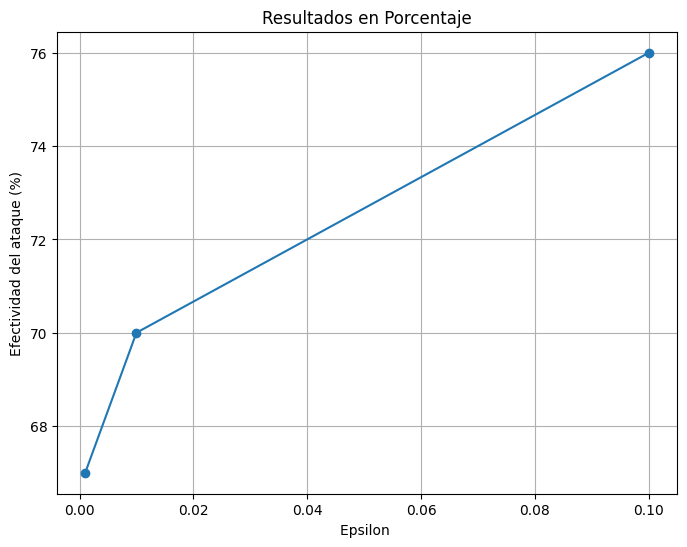

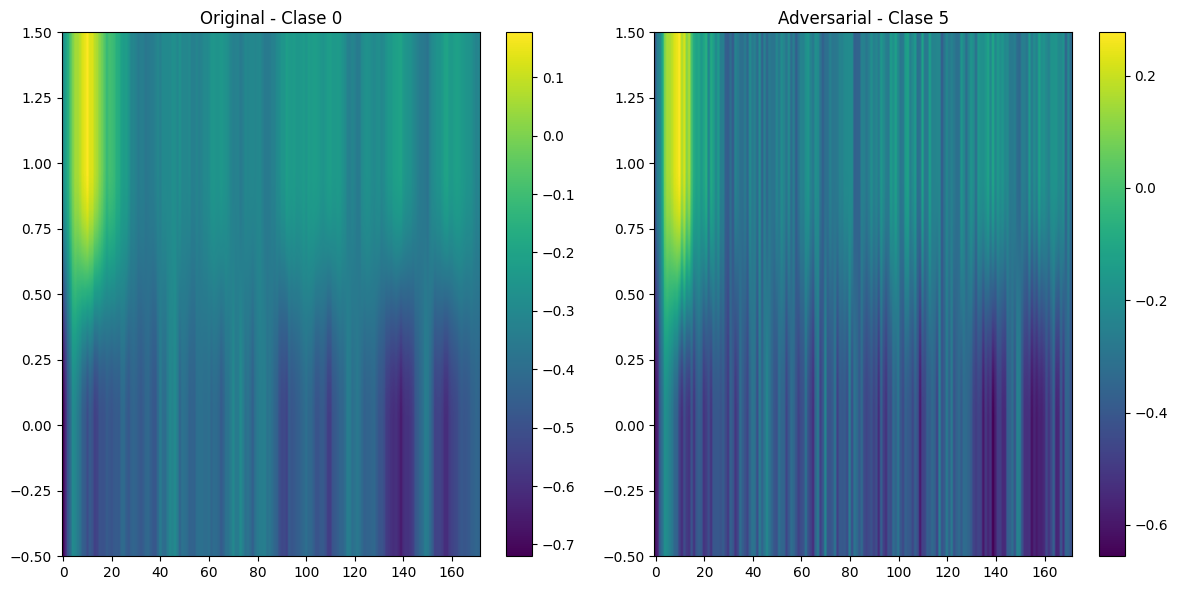

In [81]:
from foolbox.attacks import LinfDeepFoolAttack,LinfPGD,L2DeepFoolAttack
# X_train_padded, X_test_padded, y_train_numeric, y_test_numeric =
model = final_model.to(device)

# for i in range (1,11):

input_bounds = (X_train_padded.min(), X_train_padded.max())         #Creamos los límites, en este caso el minimo y máximo de nuestro conjunto de entrenamiento 

# Crear el objeto Foolbox model
fmodel = fb.PyTorchModel(model, bounds=input_bounds, device=device)

#Ejemplos que "atacaremos"
num_examples = 100
indices = np.random.choice(len(X_test_padded), num_examples, replace=False)
X_attack = torch.tensor(X_test_padded[indices], dtype=torch.float32).to(device)
print(f"Dimensiones completas X_attack: {X_attack.shape}")

y_attack = torch.tensor(y_test_numeric[indices], dtype=torch.long).to(device)
print(f"Dimensiones completas y_attack: {y_attack.shape}")

attack = L2DeepFoolAttack()
# Definimos epsilon que es el límite máximo de la magnitud de la perturbación adversarial
# epsilons = np.linspace(0.01, 0.5, 30)


# Aplicar el ataque para cada epsilon
adversarials = attack(fmodel, X_attack, y_attack,epsilons=None)

# # Verificar el tipo y la estructura de adversarials
# print(f"Tipo de adversarials: {type(adversarials)}")
# if isinstance(adversarials, torch.Tensor):
#     print(f"Shape de adversarials: {adversarials.shape}")
# elif isinstance(adversarials, (list, tuple)):
#     print(f"Longitud de adversarials: {len(adversarials)}")
#     for idx, adv in enumerate(adversarials):
#         print(f"Tipo de adversarials[{idx}]: {type(adv)}")
#         if isinstance(adv, torch.Tensor):
#             print(f"Shape de adversarials[{idx}]: {adv.shape}")
#         elif isinstance(adv, (list, tuple)):
#             print(f"Longitud de adversarials[{idx}]: {len(adv)}")
#             # Inspeccionar el primer elemento
#             first_element = adv[0]
#             print(f"Tipo de adversarials[{idx}][0]: {type(first_element)}")
#             if isinstance(first_element, torch.Tensor):
#                 print(f"Shape de adversarials[{idx}][0]: {first_element.shape}")
#             elif isinstance(first_element, np.ndarray):
#                 print(f"Shape de adversarials[{idx}][0]: {first_element.shape}")
#             else:
#                 print(f"Elemento adversarials[{idx}][0] no es un tensor ni un ndarray.")
#         else:
#             print(f"Tipo desconocido para adversarials[{idx}].")
# else:
#     print("Estructura de adversarials desconocida.")

################################################### ataque con L2 Deep Fool 
# Supongamos que ya aplicaste el ataque DeepFool
# attack = fb.attacks.L2DeepFoolAttack()

# # Obtener el número de iteraciones
# adversarials = attack(fmodel, X_attack, y_attack,epsilons=None)


# # Seleccionar los ejemplos adversariales de la última iteración
# # Obtener los ejemplos adversariales finales
# adversarial_examples = adversarials[0]  
# adversarial_examples = adversarial_examples.to(device)
# print(f"Forma de adversarial_examples: {adversarial_examples.shape}")

# # Obtener las predicciones para los ejemplos adversariales
# adversarial_preds = fmodel(adversarial_examples).argmax(axis=-1)

# success_rate_per_iter = adversarials[2].float().mean().item()
# print(f"Tasa de éxito general: {success_rate_per_iter:.4f}")

# perturbations = adversarials[1]
# l2_norms = torch.norm(perturbations.view(perturbations.size(0), -1), dim=1, p=2)
# print(f"Norma L2 promedio de las perturbaciones: {l2_norms.mean().item()}")


# # Definir la función de visualización (si no está definida)
# def plot_features(original, adversarial, index):
#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.imshow(original.T, aspect='auto', origin='lower')
#     plt.title(f'Original - Clase {y_attack[index].item()}')
#     plt.colorbar()
#     plt.subplot(1, 2, 2)
#     plt.imshow(adversarial.T, aspect='auto', origin='lower')
#     plt.title(f'Adversarial - Clase {adversarial_preds[index].item()}')
#     plt.colorbar()
#     plt.tight_layout()
#     plt.show()

# # Encontrar índices donde el ataque tuvo éxito
# successful_indices = np.where(success.cpu().numpy())[0]
# if len(successful_indices) > 0:
#     example_idx = successful_indices[0]
#     original = X_attack[example_idx].cpu().numpy()
#     adversarial = adversarial_examples[example_idx].cpu().numpy()
#     plot_features(original, adversarial, example_idx)
# else:
#     print("No hubo ataques exitosos para visualizar.")

# perturbations = adversarials[1]
# l2_norms = torch.norm(perturbations.view(perturbations.size(0), -1), dim=1, p=2)
# print(f"Norma L2 promedio de las perturbaciones: {l2_norms.mean().item()}")

# ###########################################################################################################################################################################
attack = LinfPGD()
# Visualizar un ejemplo exitoso
def plot_features(original, adversarial, index):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original.T, aspect='auto', origin='lower')
    plt.title(f'Original - Clase {y_attack[index].item()}')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(adversarial.T, aspect='auto', origin='lower')
    plt.title(f'Adversarial - Clase {adversarial_preds[index].item()}')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

epsilons = [0.001,0.01,0.1]
adversarials = attack(fmodel, X_attack, y_attack,epsilons=epsilons)

adversarial_examples_list = adversarials[0]  # Lista de ejemplos adversariales por epsilon
perturbations_list = adversarials[1]         # Lista de perturbaciones por epsilon
success_flags = adversarials[2]              # Tensor de éxitos de forma [4, 100]
resultados=[]                                # Almacenar resultados 
# Iterar sobre cada epsilon y los ejemplos adversariales correspondientes
for i, epsilon in enumerate(epsilons):
    adversarial_examples = adversarial_examples_list[i]  # Tensor de forma [100, 172, 2]
    
    # Asegurar que los ejemplos adversariales estén en el dispositivo correcto ¿Porque hay que hacer esto?
    adversarial_examples = adversarial_examples.to(device)
    
    # Obtener las predicciones adversariales
    adversarial_preds = fmodel(adversarial_examples).argmax(axis=-1)  # Tensor de forma [100]
    
    # Calcular la tasa de éxito del ataque
    success = adversarial_preds != y_attack
    success_rate = success.float().mean().item()
    print(f"Tasa de éxito para epsilon={epsilon}: {success_rate * 100:.2f}%")
    resultados.append(success_rate)

resultados_percent = [r * 100 for r in resultados]


# Crear el plot
plt.figure(figsize=(8, 6))
plt.plot(epsilons , resultados_percent, marker='o', linestyle='-')
plt.title("Resultados en Porcentaje")
plt.xlabel("Epsilon ")
plt.ylabel("Efectividad del ataque (%)")
plt.grid(True)
plt.show()



# Seleccionar el índice del epsilon para visualizar (por ejemplo, el de epsilon=0.1)
epsilon_target = 0.1

# Convertir epsilons a array de NumPy si es necesario
if isinstance(epsilons, list):
    epsilons_array = np.array(epsilons)
else:
    epsilons_array = epsilons

epsilon_index = (np.abs(epsilons_array - epsilon_target)).argmin()

# Extraer los ejemplos adversariales y predicciones correspondientes al epsilon seleccionado
adversarial_examples = adversarial_examples_list[epsilon_index]  # Tensor de forma [100, 172, 2]
adversarial_examples = adversarial_examples.to(device)

# Obtener las predicciones adversariales correspondientes
adversarial_preds = fmodel(adversarial_examples).argmax(axis=-1)  # Tensor de forma [100]


# Obtener los índices de ejemplos donde el ataque tuvo éxito
success = adversarial_preds != y_attack
successful_indices = np.where(success.cpu().numpy())[0]

if len(successful_indices) > 0:
    example_idx = successful_indices[0]
    original = X_attack[example_idx].cpu().numpy()
    adversarial = adversarial_examples[example_idx].cpu().numpy()
    plot_features(original, adversarial, example_idx)
else:
    print("No hubo ataques exitosos para visualizar.")


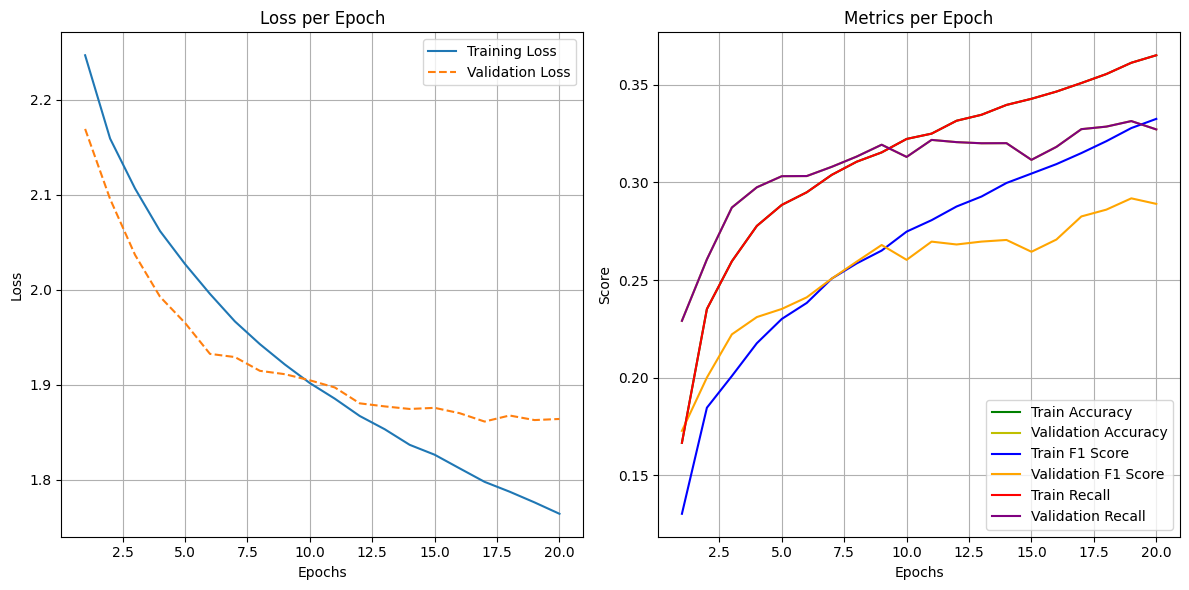

In [ ]:
import numpy as np
from visualizations import plot_DL_results

# Assuming 'results' is a list of dictionaries with multiple metrics as keys
metrics = [
    'train_losses', 'valid_losses', 'train_accuracies', 'train_f1_scores', 
    'train_recalls', 'valid_accuracies', 'valid_f1_scores', 'valid_recalls'
]

# Initialize dictionaries to store the mean values for each metric
mean_metrics = {metric: [] for metric in metrics}

# Assuming all folds have the same number of epochs
num_epochs = len(results[0]['train_losses'])

# Loop through each epoch
for epoch in range(num_epochs):
    for metric in metrics:
        # Collect values for this metric from all folds for the current epoch
        metric_values = [fold[metric][epoch] for fold in results]
        mean_metric = np.mean(metric_values)  # Calculate the mean of the metric values
        mean_metrics[metric].append(mean_metric)  # Append to the corresponding list

# Now, pass the mean values to the plot_DL_results function
plot_DL_results(
    mean_metrics['train_accuracies'],
    mean_metrics['valid_accuracies'],
    mean_metrics['train_losses'],
    mean_metrics['valid_losses'],
    mean_metrics['train_f1_scores'],
    mean_metrics['valid_f1_scores'],
    mean_metrics['train_recalls'],
    mean_metrics['valid_recalls']
)


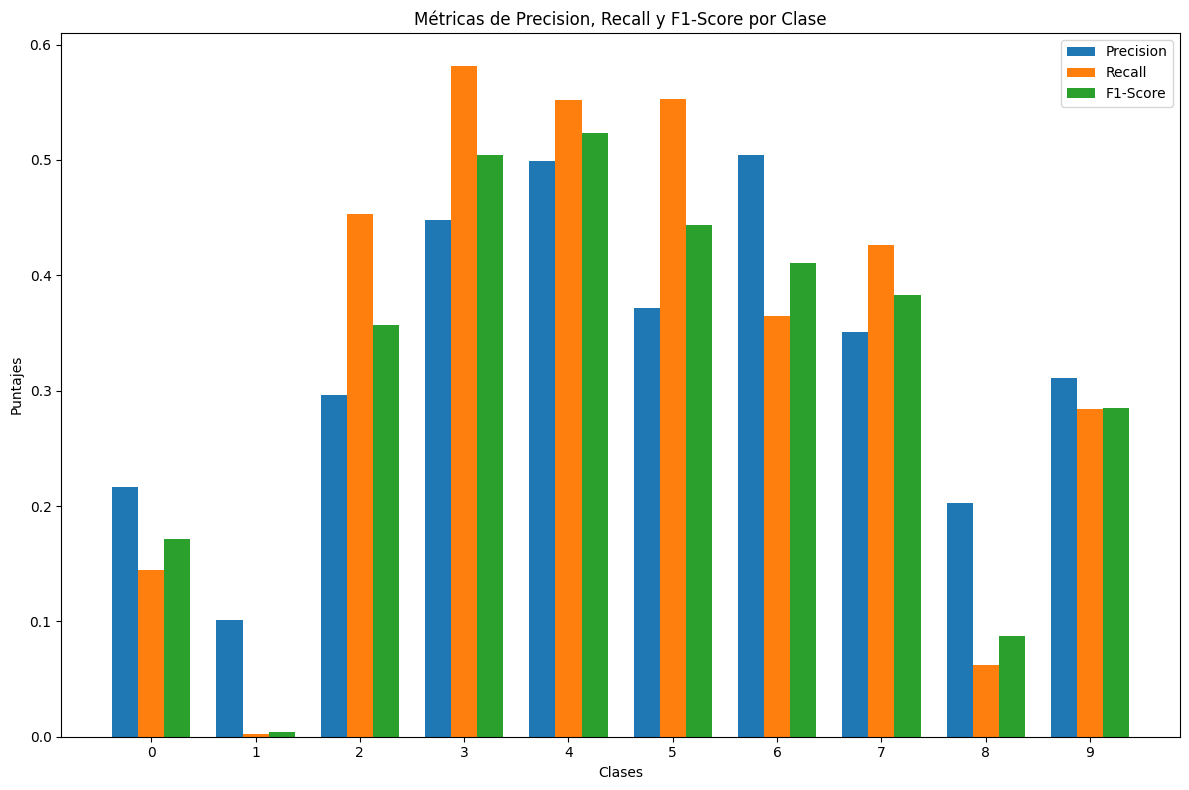

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Inicializa un diccionario para almacenar las medias de cada clase y cada métrica
mean_class_metrics = {}

# Asumiendo que 'results' es una lista de diccionarios con las métricas de cada fold
for fold in results:
    class_metrics = fold['train_class_metrics'][-1]  # Accede a las métricas de la última época
    
    # Itera sobre las clases (0-9)
    for class_id, metrics in class_metrics.items():
        if class_id != 'accuracy' and class_id != 'macro avg' and class_id != 'weighted avg':
            # Si la clase aún no tiene una entrada, inicializa su lista para las métricas
            if class_id not in mean_class_metrics:
                mean_class_metrics[class_id] = {'precision': [], 'recall': [], 'f1-score': []}
            
            # Agrega las métricas actuales a las listas correspondientes
            mean_class_metrics[class_id]['precision'].append(metrics['precision'])
            mean_class_metrics[class_id]['recall'].append(metrics['recall'])
            mean_class_metrics[class_id]['f1-score'].append(metrics['f1-score'])

# Ahora, calcula la media para cada clase
for class_id in mean_class_metrics:
    for metric in ['precision', 'recall', 'f1-score']:
        # Calcula la media de la métrica para esta clase a través de todos los folds
        mean_class_metrics[class_id][metric] = np.mean(mean_class_metrics[class_id][metric])

# Ahora vamos a graficar
# Extraemos los valores para el gráfico
classes = list(mean_class_metrics.keys())
precision_values = [mean_class_metrics[class_id]['precision'] for class_id in classes]
recall_values = [mean_class_metrics[class_id]['recall'] for class_id in classes]
f1_score_values = [mean_class_metrics[class_id]['f1-score'] for class_id in classes]

# Configuramos la posición de las barras
x = np.arange(len(classes))  # El número de clases
width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(12, 8))

bars1 = ax.bar(x - width, precision_values, width, label='Precision')
bars2 = ax.bar(x, recall_values, width, label='Recall')
bars3 = ax.bar(x + width, f1_score_values, width, label='F1-Score')

# Añadir etiquetas y título
ax.set_xlabel('Clases')
ax.set_ylabel('Puntajes')
ax.set_title('Métricas de Precision, Recall y F1-Score por Clase')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()



In [ ]:
metrics = ["precision","recall","f1-score","support"]
mean_metrics = {metric: [] for metric in metrics}

for fold in results : 
    macro_Avg = fold['train_class_metrics'][-1]["macro avg"]
    for key,value in macro_Avg.items() :
        mean_metrics[key] = np.mean(value)

print(mean_metrics)

{'precision': 0.3204980651639731, 'recall': 0.34135328820351685, 'f1-score': 0.31881387873428113, 'support': 7895.0}


In [ ]:
metrics = ["precision","recall","f1-score","support"]
mean_metrics = {metric: [] for metric in metrics}

for fold in results : 
    macro_Avg = fold['train_class_metrics'][-1]
    print(macro_Avg)

{'0': {'precision': 0.2646048109965636, 'recall': 0.1711111111111111, 'f1-score': 0.2078272604588394, 'support': 900.0}, '1': {'precision': 0.6, 'recall': 0.007633587786259542, 'f1-score': 0.01507537688442211, 'support': 393.0}, '2': {'precision': 0.319650067294751, 'recall': 0.5277777777777778, 'f1-score': 0.39815590947191953, 'support': 900.0}, '3': {'precision': 0.4762376237623762, 'recall': 0.5344444444444445, 'f1-score': 0.5036649214659686, 'support': 900.0}, '4': {'precision': 0.5209163346613546, 'recall': 0.5811111111111111, 'f1-score': 0.5493697478991597, 'support': 900.0}, '5': {'precision': 0.36431784107946025, 'recall': 0.5376106194690266, 'f1-score': 0.4343163538873995, 'support': 904.0}, '6': {'precision': 0.4859154929577465, 'recall': 0.40707964601769914, 'f1-score': 0.44301765650080255, 'support': 339.0}, '7': {'precision': 0.40096230954290296, 'recall': 0.5681818181818182, 'f1-score': 0.4701457451810061, 'support': 880.0}, '8': {'precision': 0.12631578947368421, 'recall